# Idea 

- Investigate the distribution of the embeddings for the C Atrox sequence
- Just 9 dimensions in the embeddings where the avg saliency is >= 0.14: [   4,  716, 1116, 1512, 1535, 2282, 2327, 2482, 2527]

In [11]:
import torch
import numpy as np
import pandas as pd
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
# load the sequence from the fasta file 
fasta_path = '../data/MF974418_1_Crotalus_atrox.fasta'
with open(fasta_path) as f: 
    fasta = f.readlines()
    sequence = ''.join(fasta[1:]).replace('\n', '')
print(sequence)

SLVQFETLIMKIAGRSGLLWYSAYGCYCGWGGHGLPQDATDRCCFVHDCCYGKATDCNPKTVSYTYSEENGEIICGGDDPCGTQICECDKAAAICFRDNIPSYDNKYWLFPPKNCREEPEPC


In [13]:
# Select embedding dimensions to extract
embedding_dimensions = [4, 716, 1116, 1512, 1535, 2282, 2327, 2482, 2527]

# Load and process embedding of C Atrox
embedding_file = '/mnt/c/Users/nicol/Documents/thesis/VespaG/output_c_atrox/esm2_embeddings.h5'

with h5py.File(embedding_file, 'r') as f:
    protein_id = list(f.keys())[0]
    embedding = f[protein_id][()]
    embedding = torch.tensor(embedding)

protein_id, embedding.shape

('MF974418_1_Crotalus_atrox', torch.Size([122, 2560]))

In [14]:
# make a dataframe with the embedding
df = pd.DataFrame(embedding.numpy())
# add the sequence to the dataframe
df['wildtype'] = list(sequence)
df['residue_index'] = list(range(1, len(sequence) + 1))
# tidy up the dataframe 
df = df.melt(id_vars=['wildtype', 'residue_index'], var_name='dimension', value_name='embedding_value')
df['dimension'] = df['dimension'].astype(float)
df.head()

,wildtype,residue_index,dimension,embedding_value
0,S,1,0.0,0.297363
1,L,2,0.0,0.369385
2,V,3,0.0,0.373047
3,Q,4,0.0,0.199097
4,F,5,0.0,0.402100


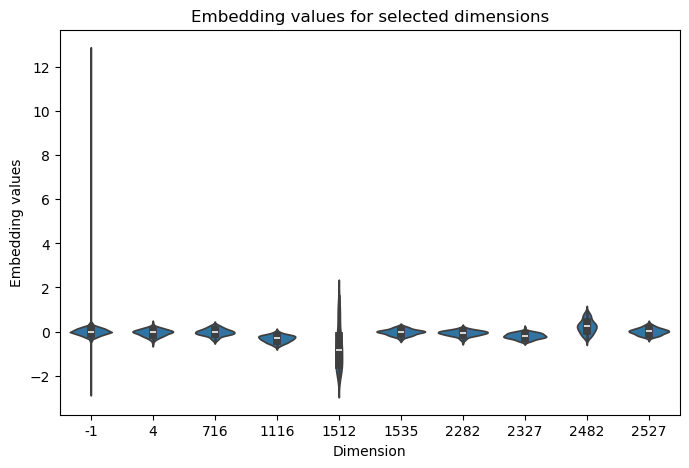

In [15]:
# differentiate between the selected dimensions and the rest with a new column 
selected_dimensions = df.copy()
selected_dimensions['selected_dimension'] = -1
selected_dimensions.loc[selected_dimensions['dimension'].isin(embedding_dimensions), 'selected_dimension'] = selected_dimensions[selected_dimensions['dimension'].isin(embedding_dimensions)]['dimension']

# for each of the selected dimensions, plot the embedding values with a violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(x='selected_dimension', y='embedding_value', data=selected_dimensions)
plt.xlabel('Dimension')
plt.ylabel('Embedding values')
plt.title('Embedding values for selected dimensions')
plt.show()

Text(0.5, 1.0, 'Distribution of range of embedding values')

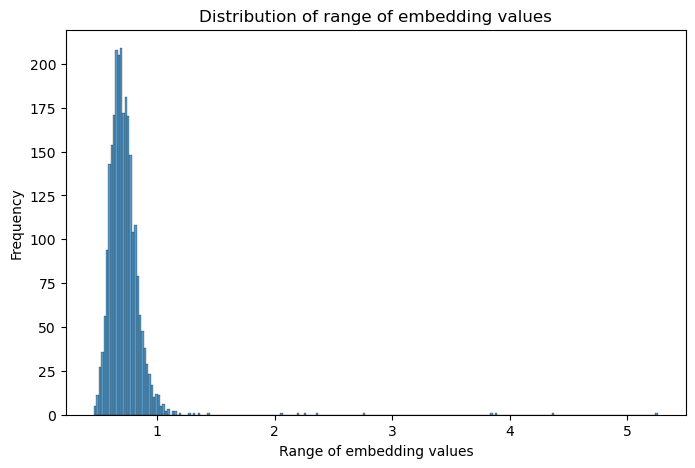

In [16]:
# figure out whether there is just one dimension where range of the embedding values is very different to the rest 
# plot the distribution of the range of the values 
range_df = df.groupby('dimension')['embedding_value'].agg(lambda x: np.max(x) - np.min(x)).to_frame(name='range').reset_index()
plt.figure(figsize=(8, 5))
sns.histplot(range_df['range'])
plt.xlabel('Range of embedding values')
plt.ylabel('Frequency')
plt.title('Distribution of range of embedding values')

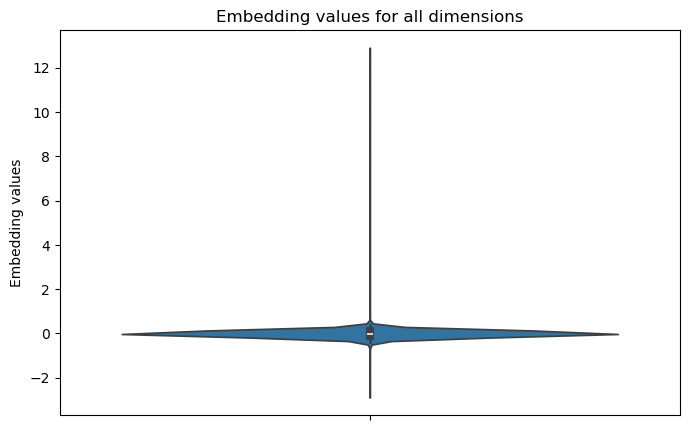

In [17]:
# violin plot of all embedding values 
plt.figure(figsize=(8, 5))
sns.violinplot(y='embedding_value', data=df)
plt.ylabel('Embedding values')
plt.title('Embedding values for all dimensions')
plt.show()

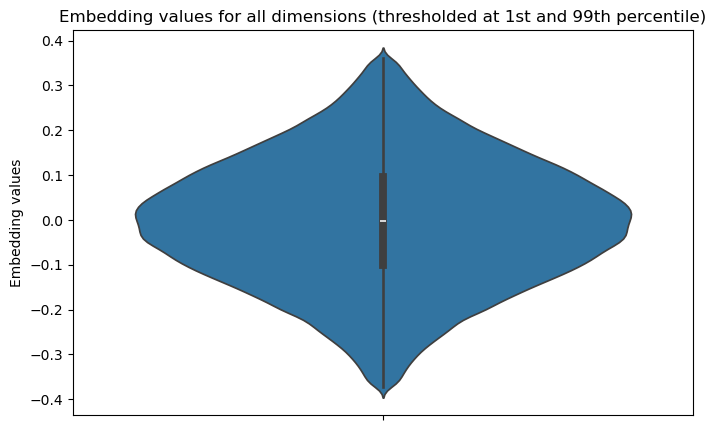

In [18]:
# exclude 1st and 99th percentile of embedding values 
percentile = 99
upper_bound = np.percentile(df['embedding_value'], percentile)
lower_bound = np.percentile(df['embedding_value'], 100 - percentile)
q_thresholded_embeddings = df[(df['embedding_value'] > lower_bound) & (df['embedding_value'] < upper_bound)]

# violin plot of thresholded embedding values
plt.figure(figsize=(8, 5))
sns.violinplot(y='embedding_value', data=q_thresholded_embeddings)
plt.ylabel('Embedding values')
plt.title('Embedding values for all dimensions (thresholded at 1st and 99th percentile)')
plt.show()

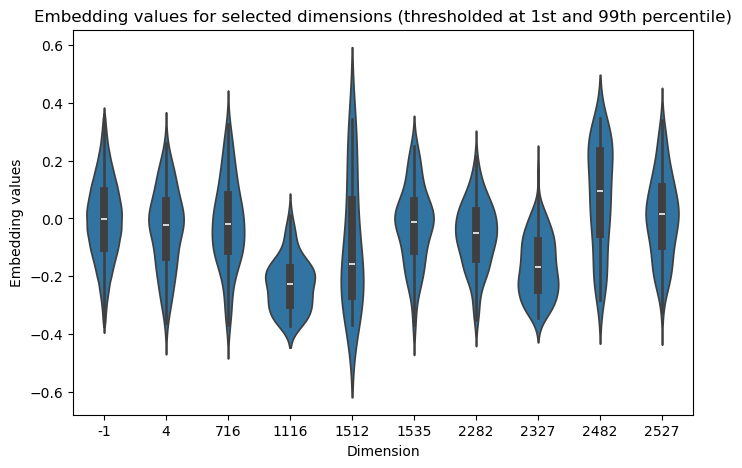

In [19]:
# same plot but with selected dimensions
selected_dimensions = q_thresholded_embeddings.copy()
selected_dimensions['selected_dimension'] = -1
selected_dimensions.loc[selected_dimensions['dimension'].isin(embedding_dimensions), 'selected_dimension'] = selected_dimensions[selected_dimensions['dimension'].isin(embedding_dimensions)]['dimension']

plt.figure(figsize=(8, 5))
sns.violinplot(x='selected_dimension', y='embedding_value', data=selected_dimensions)
plt.xlabel('Dimension')
plt.ylabel('Embedding values')
plt.title('Embedding values for selected dimensions (thresholded at 1st and 99th percentile)')
plt.show()

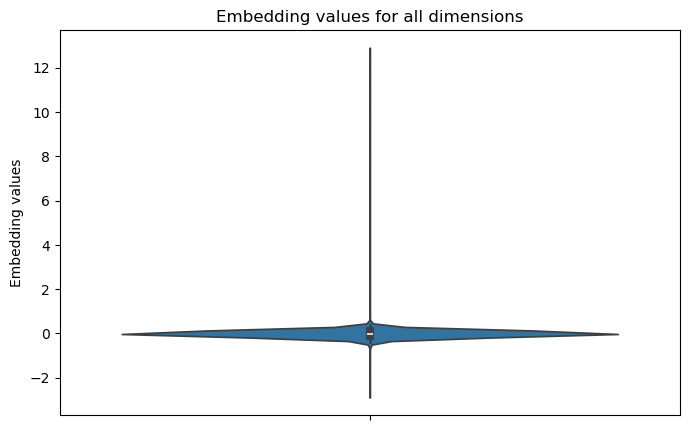

In [20]:
# violin plot of all embedding values 
plt.figure(figsize=(8, 5))
sns.violinplot(y='embedding_value', data=df)
plt.ylabel('Embedding values')
plt.title('Embedding values for all dimensions')
plt.show()

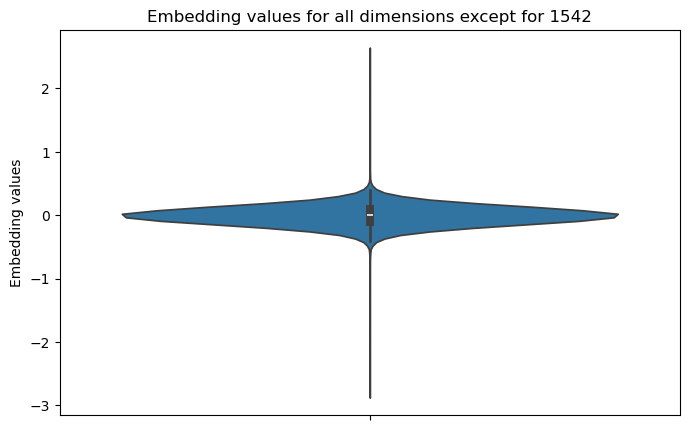

In [21]:
# violin plot of thresholded embedding values excluding dimension 1542
plt.figure(figsize=(8, 5))
sns.violinplot(y='embedding_value', data=df.query('dimension != 1542'))
plt.ylabel('Embedding values')
plt.title('Embedding values for all dimensions except for 1542')
plt.show()

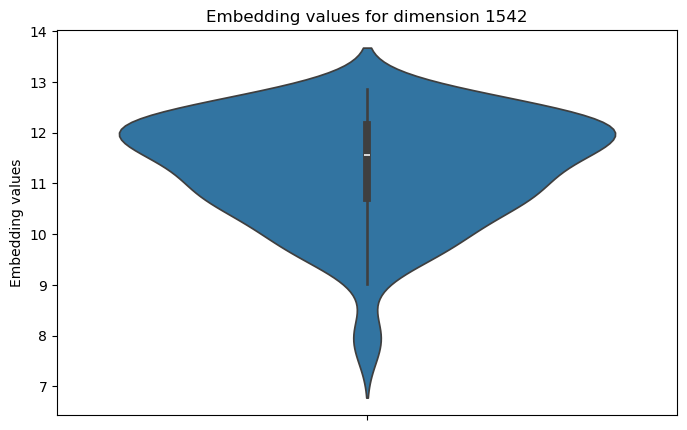

In [22]:
# violin plot of thresholded embedding values
plt.figure(figsize=(8, 5))
sns.violinplot(y='embedding_value', data=df.query('dimension == 1542'))
plt.ylabel('Embedding values')
plt.title('Embedding values for dimension 1542')
plt.show()

## What is the effect of modifying embeddings? 

In [23]:
import sys 
sys.path.append('../vespag')

from parse.vep_scores import get_vespag_scores, get_gemme_scores

In [24]:
vespag_path = '/mnt/f/nicole/pla2_vespag/MF974418_1_Crotalus_atrox.csv'
vespag_scores = get_vespag_scores(vespag_path)
vespag_scores['mutation_effect'] = - vespag_scores['vespag']
vespag_scores['norm_mutation_effect'] = (vespag_scores['mutation_effect'] - vespag_scores['mutation_effect'].min()) / (vespag_scores['mutation_effect'].max() - vespag_scores['mutation_effect'].min())
vespag_scores.head()

,residue,mutation,vespag,mutation_effect,norm_mutation_effect
0,S1,S1A,-2.733914,2.733914,0.338812
1,S1,S1Y,-4.639794,4.639794,0.595842
2,S1,S1W,-4.962937,4.962937,0.639421
3,S1,S1V,-4.356812,4.356812,0.557678
4,S1,S1T,-2.385255,2.385255,0.291791


In [25]:
gemme_path = '/mnt/f/nicole/pla2_gemme/MF974418_1_Crotalus_atrox/MF974418_1_Crotalus_atrox_normPred_evolCombi.txt'
gemme_scores = get_gemme_scores(gemme_path)
gemme_scores['mutation_effect'] = - gemme_scores['gemme']
gemme_scores['norm_mutation_effect'] = (gemme_scores['mutation_effect'] - gemme_scores['mutation_effect'].min()) / (gemme_scores['mutation_effect'].max() - gemme_scores['mutation_effect'].min())
gemme_scores.head()

,residue,mutation,gemme,mutation_effect,norm_mutation_effect
0,S1,S1A,-0.862866,0.862866,0.101697
1,S1,S1V,-3.140315,3.140315,0.354269
2,S1,S1T,-2.009272,2.009272,0.228835
3,S1,S1R,-3.140315,3.140315,0.354269
4,S1,S1Q,-3.140315,3.140315,0.354269


In [26]:
gemme_scores.columns

Index(['residue', 'mutation', 'gemme', 'mutation_effect',
       'norm_mutation_effect'],
      dtype='object')

In [27]:
scores = vespag_scores[['residue', 'mutation', 'norm_mutation_effect']].merge(gemme_scores[['residue', 'mutation', 'norm_mutation_effect']], on=['residue', 'mutation'], suffixes=('_vespag', '_gemme'))
scores.head()

,residue,mutation,norm_mutation_effect_vespag,norm_mutation_effect_gemme
0,S1,S1A,0.338812,0.101697
1,S1,S1Y,0.595842,0.354269
2,S1,S1W,0.639421,0.354269
3,S1,S1V,0.557678,0.354269
4,S1,S1T,0.291791,0.228835


In [28]:
# determine a mutation for which vespag and gemme are both high and similar
scores['difference'] = np.abs(scores['norm_mutation_effect_vespag'] - scores['norm_mutation_effect_gemme'])
scores.sort_values('difference', ascending=True).head()

,residue,mutation,norm_mutation_effect_vespag,norm_mutation_effect_gemme,difference
1567,T83,T83L,0.151507,0.151538,0.000031
511,Y27,Y27H,0.247851,0.247897,0.000046
2025,Y107,Y107A,0.384210,0.383874,0.000336
2144,K113,K113H,0.086314,0.086744,0.000431
509,Y27,Y27F,0.094635,0.095084,0.000449


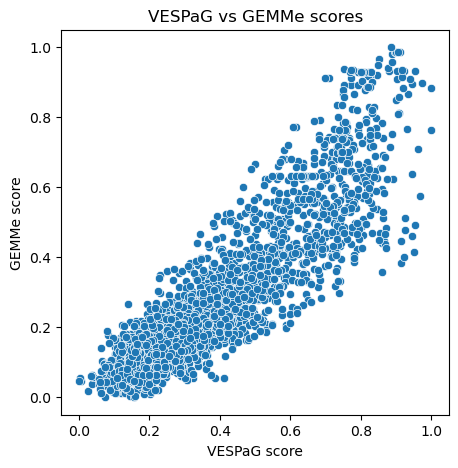

In [29]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='norm_mutation_effect_vespag', y='norm_mutation_effect_gemme', data=scores)
plt.xlabel('VESPaG score')
plt.ylabel('GEMMe score')
plt.title('VESPaG vs GEMMe scores')
plt.show()

In [30]:
# Compute combined score
scores['combined_score'] = (scores['norm_mutation_effect_vespag'] + scores['norm_mutation_effect_gemme']) / 2

# Select the mutation with the highest combined score
best_mutation = scores.loc[scores['combined_score'].idxmax()]
best_mutation

residue                             C28
mutation                           C28Q
norm_mutation_effect_vespag    0.911291
norm_mutation_effect_gemme     0.985631
difference                      0.07434
combined_score                 0.948461
Name: 519, dtype: object

## Modify the embeddings and concentrate how the scores for the entire sequence evolve

- once for each dimension in the embeddings: Set the value to 0 
- once for each dimension in the embeddings: Set the value to 1
- once for each dimension in the embeddings: Set the value to -1
- once for each dimension in the embeddings: Set the value to 10
- once for each dimension in the embeddings: Set the value to -10

Concentrate on the selected embeddings: Here the modification should lead to a larger difference

In [31]:
import os

In [32]:
embedding.shape

torch.Size([122, 2560])

In [ ]:
modified_values = [0, -1, 1]

modified_embeddings_folder = '/mnt/f/nicole/modified_embeddings_c_atrox/'
os.makedirs(modified_embeddings_folder, exist_ok=True)

# for each dimension in the embeddings, set the values to the modified value and store the embeddings in a new .h5 file
for dimension in tqdm(range(embedding.shape[1]), desc='Processing dimensions', unit='dimension'):
    for modified_value in modified_values:
        modified_embedding = embedding.clone()
        modified_embedding[: , dimension] = modified_value
        modified_embedding_file = os.path.join(modified_embeddings_folder, f'modified_embedding_{modified_value}_{dimension}.h5')
        with h5py.File(modified_embedding_file, 'w') as f:
            f.create_dataset(protein_id, data=modified_embedding.numpy())

# Analyse effect of changing the embeddings value for C28 in C Atrox 

## Remeber that C28Q had the highest combined score between VespaG and Gemme

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 

import sys 
sys.path.append('../vespag')

from tqdm import tqdm
from parse.vep_scores import get_vespag_scores, get_gemme_scores
from src.constants import GEMME_ALPHABET

In [38]:
! ls /mnt/f/nicole/output_c_atrox_modified/ | head

modified_embedding_-1_0
modified_embedding_-1_1
modified_embedding_-1_10
modified_embedding_-1_100
modified_embedding_-1_1000
modified_embedding_-1_1001
modified_embedding_-1_1002
modified_embedding_-1_1003
modified_embedding_-1_1004
modified_embedding_-1_1005
ls: write error: Broken pipe


In [41]:
vespag_folders = '/mnt/f/nicole/output_c_atrox_modified/'

folders = os.listdir(vespag_folders)

modified_results = []

for folder in tqdm(folders, desc="Processing folders", unit="folder"):
    # get the modified value and dimension from the folder name
    modified_value, dimension = folder.replace("modified_embedding_", '').split('_')
    modified_value = int(modified_value)
    dimension = int(dimension)
    
    # get the vespag results file in the folder
    files = os.listdir(os.path.join(vespag_folders, folder))
    assert len(files) == 1, f"Expected 1 file in folder {folder}, got {len(files)}"

    vespag_path = os.path.join(vespag_folders, folder, files[0])
    vespag_scores = get_vespag_scores(vespag_path)
    vespag_scores['modified_value'] = modified_value
    vespag_scores['dimension'] = dimension

    # store the results 
    modified_results.append(vespag_scores)

Processing folders: 100%|██████████| 7680/7680 [03:06<00:00, 41.13folder/s] 


In [42]:
print('Concatenating results')
modified_results = pd.concat(modified_results)
print('Getting the mutation effect')
modified_results['mutation_effect'] = - modified_results['vespag']
# normalize the mutation effect into [0,1] for each batch of results
print('Normalizing the mutation effect')
modified_results['norm_mutation_effect'] = modified_results.groupby(['modified_value', 'dimension'])['mutation_effect'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
print('Shape of the dataframe: ', modified_results.shape)
modified_results.head()

Concatenating results
Getting the mutation effect
Normalizing the mutation effect
Shape of the dataframe:  (17802240, 7)


,residue,mutation,vespag,modified_value,dimension,mutation_effect,norm_mutation_effect
0,S1,S1A,-2.950175,-1,0,2.950175,0.360040
1,S1,S1Y,-4.814111,-1,0,4.814111,0.610457
2,S1,S1W,-5.112204,-1,0,5.112204,0.650506
3,S1,S1V,-4.568451,-1,0,4.568451,0.577453
4,S1,S1T,-2.605190,-1,0,2.605190,0.313692


In [43]:
# add the original vespag results so that we can evaluate the change
ORIGINAL_VALUE = 99 # need some value that is not in the modified values (dirty hack) should work because dimension is always -1 as well (NaN not an option becuase this leads to problems in group by operations)
vespag_path = '/mnt/f/nicole/pla2_vespag/MF974418_1_Crotalus_atrox.csv'
original_vespag_result = get_vespag_scores(vespag_path)
original_vespag_result['mutation_effect'] = - original_vespag_result['vespag']
original_vespag_result['norm_mutation_effect'] = (original_vespag_result['mutation_effect'] - original_vespag_result['mutation_effect'].min()) / (original_vespag_result['mutation_effect'].max() - original_vespag_result['mutation_effect'].min())
original_vespag_result['modified_value'] = ORIGINAL_VALUE
original_vespag_result['dimension'] = -1
original_vespag_result.head()

,residue,mutation,vespag,mutation_effect,norm_mutation_effect,modified_value,dimension
0,S1,S1A,-2.733914,2.733914,0.338812,99,-1
1,S1,S1Y,-4.639794,4.639794,0.595842,99,-1
2,S1,S1W,-4.962937,4.962937,0.639421,99,-1
3,S1,S1V,-4.356812,4.356812,0.557678,99,-1
4,S1,S1T,-2.385255,2.385255,0.291791,99,-1


In [44]:
modified_results = pd.concat([modified_results, original_vespag_result])

In [45]:
# load the gemme results 
gemme_path = '/mnt/f/nicole/pla2_gemme/MF974418_1_Crotalus_atrox/MF974418_1_Crotalus_atrox_normPred_evolCombi.txt'
gemme_scores = get_gemme_scores(gemme_path)
gemme_scores['mutation_effect'] = - gemme_scores['gemme']
gemme_scores['norm_mutation_effect'] = (gemme_scores['mutation_effect'] - gemme_scores['mutation_effect'].min()) / (gemme_scores['mutation_effect'].max() - gemme_scores['mutation_effect'].min())
gemme_scores.head()

,residue,mutation,gemme,mutation_effect,norm_mutation_effect
0,S1,S1A,-0.862866,0.862866,0.101697
1,S1,S1V,-3.140315,3.140315,0.354269
2,S1,S1T,-2.009272,2.009272,0.228835
3,S1,S1R,-3.140315,3.140315,0.354269
4,S1,S1Q,-3.140315,3.140315,0.354269


In [46]:
# merge the results 
modified_scores = pd.merge(modified_results[['residue', 'mutation', 'norm_mutation_effect', 'dimension', 'modified_value']], gemme_scores[['residue', 'mutation', 'norm_mutation_effect']], on=['residue', 'mutation'], suffixes=('_vespag', '_gemme'))
print(modified_scores.shape)
modified_scores.head()

(17804558, 6)


,residue,mutation,norm_mutation_effect_vespag,dimension,modified_value,norm_mutation_effect_gemme
0,S1,S1A,0.360040,0,-1,0.101697
1,S1,S1Y,0.610457,0,-1,0.354269
2,S1,S1W,0.650506,0,-1,0.354269
3,S1,S1V,0.577453,0,-1,0.354269
4,S1,S1T,0.313692,0,-1,0.228835


In [47]:
# for each of the modified batches, calculate the spearman correlation between results and the gemme results
# store the results for plotting later on 
correlations = []

def calculate_spearman_correlation(group):
    return group['norm_mutation_effect_vespag'].corr(group['norm_mutation_effect_gemme'], method='spearman')

correlations = modified_scores.groupby(['modified_value', 'dimension']).apply(calculate_spearman_correlation).reset_index(name='spearman_correlation')
correlations.head()

/tmp/ipykernel_308035/4075619616.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = modified_scores.groupby(['modified_value', 'dimension']).apply(calculate_spearman_correlation).reset_index(name='spearman_correlation')


,modified_value,dimension,spearman_correlation
0,-1,0,0.885567
1,-1,1,0.885490
2,-1,2,0.884400
3,-1,3,0.885128
4,-1,4,0.884367


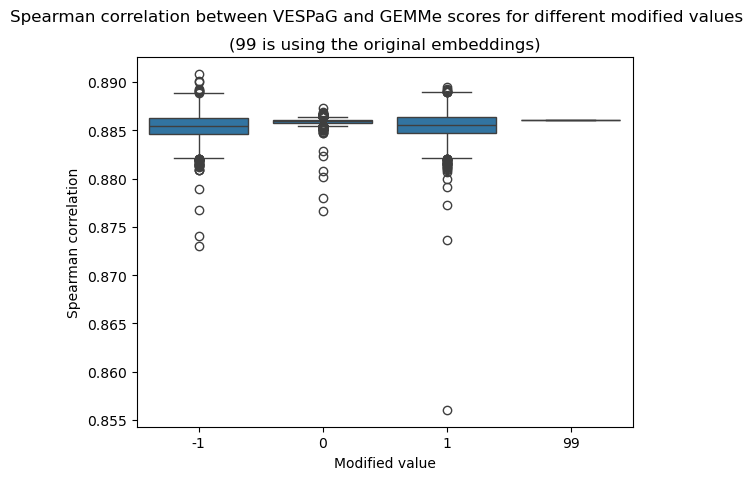

In [48]:
# for each modified value, plot the distribution of the spearman correlation values 
sns.boxplot(x='modified_value', y='spearman_correlation', data=correlations)
plt.xlabel('Modified value')
plt.ylabel('Spearman correlation')
plt.title('(99 is using the original embeddings)')
plt.suptitle('Spearman correlation between VESPaG and GEMMe scores for different modified values')
plt.show()

Modifying the embeddings worsens the correlation between VespaG and Gemme in a lot of cases, but not in all cases

In [51]:
correlations.query("spearman_correlation < 0.875")

,modified_value,dimension,spearman_correlation
696,-1,696,0.873030
1542,-1,1542,0.874063
6632,1,1512,0.856041
7622,1,2502,0.873633


In [57]:
original_correlation = correlations[correlations.dimension == -1].iloc[0].spearman_correlation
correlations[correlations.spearman_correlation > original_correlation][['modified_value', 'dimension']].drop_duplicates()

,modified_value,dimension
5,-1,5
12,-1,12
21,-1,21
24,-1,24
30,-1,30
...,...,...
7671,1,2551
7673,1,2553
7674,1,2554
7676,1,2556


In 2453 out of 7680 configurations, changing the embeddings value, improves the correlations between VespaG and Gemme. 

In [ ]:
# which mutation leads to the lowest mutational effect 
set_to_zero = correlations[correlations.modified_value == 0]
set_to_zero[set_to_zero.spearman_correlation < 0.88]

,modified_value,dimension,spearman_correlation
4072,0,1512,0.877947
4102,0,1542,0.876688


: 

Changing the embeddings for dimension 1542 has the worse effect on the correlation between the VespaG and Gemme Scores.

In [ ]:
# select the C28 residue, because we changed the embedding values for this residue
c28_scores = modified_scores.query("residue == 'C28'").copy()
print(c28_scores.shape)
c28_scores.head()

In [ ]:
tidy_c28_scores = c28_scores.melt(id_vars=['residue', 'mutation', 'dimension', 'modified_value'], var_name='method', value_name='norm_mutation_effect')
tidy_c28_scores['method'] = tidy_c28_scores['method'].str.replace('norm_mutation_effect_', '')
# filter original scores for gemme 
tidy_c28_scores = tidy_c28_scores[~((tidy_c28_scores["method"] == 'gemme') & (~(tidy_c28_scores["dimension"] == -1)))]
tidy_c28_scores.head()

In [ ]:
tidy_c28_scores['group'] = 'dimension_' + tidy_c28_scores['dimension'].astype(str) + '_embedding_' + tidy_c28_scores['modified_value'].astype(str)
tidy_c28_scores.loc[(tidy_c28_scores['dimension'] == -1) & (tidy_c28_scores['method'] == 'vespag'), 'group'] = 'original_vespag'
tidy_c28_scores.loc[(tidy_c28_scores['dimension'] == -1) & (tidy_c28_scores['method'] == 'gemme'), 'group'] = 'original_gemme'
tidy_c28_scores.head()

In [ ]:
tidy_c28_gemme = tidy_c28_scores.query("method == 'gemme'").copy()
tidy_c28_vespag = tidy_c28_scores.query("method == 'vespag'").copy()
tidy_c28_vespag['modification'] = "Vespa_" + tidy_c28_vespag.modified_value.astype(str)
tidy_c28_vespag.loc[tidy_c28_vespag['modified_value'] == 99, 'modification'] = 'Vespa_original'

In [ ]:
# we want to compare the evolvelement of the values for c28 
# first plot the gemme scores 
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mutation', y='norm_mutation_effect', data=tidy_c28_gemme, label='GEMME', color='blue', zorder=2)
sns.scatterplot(x='mutation', y='norm_mutation_effect', data=tidy_c28_vespag.query("dimension == -1"), color='red', label='VespaG Original', zorder=2)
sns.boxplot(x='mutation', y='norm_mutation_effect', hue='modification', data=tidy_c28_vespag.query("dimension > -1"), zorder=1)
plt.legend()
plt.show()

In [ ]:
tidy_c28_scores_gemme = tidy_c28_scores.query("method == 'gemme'").copy().drop(['group', 'dimension', 'modified_value', 'method'], axis=1)
tidy_c28_scores_gemme = tidy_c28_scores_gemme.rename(columns={'norm_mutation_effect': 'gemme_mutation_effect'})
tidy_c28_scores_vespag_original = tidy_c28_scores.query("method == 'vespag' and group == 'original_vespag'").copy().drop(['group', 'dimension', 'modified_value', 'method'], axis=1)
tidy_c28_scores_vespag_original = tidy_c28_scores_vespag_original.rename(columns={'norm_mutation_effect': 'original_vespag_mutation_effect'})
tidy_c28_scores_vespag_modified = tidy_c28_scores.query("method == 'vespag' and group != 'original_vespag'").copy().drop(['group', 'method'], axis=1)
tidy_c28_scores_vespag_modified = tidy_c28_scores_vespag_modified.rename(columns={'norm_mutation_effect': 'modified_vespag_mutation_effect'})
comparison_c28_scores = tidy_c28_scores_vespag_modified.merge(tidy_c28_scores_vespag_original, on=['residue', 'mutation'])
comparison_c28_scores = comparison_c28_scores.merge(tidy_c28_scores_gemme, on=['residue', 'mutation'])
comparison_c28_scores['vespag_delta'] = (comparison_c28_scores.original_vespag_mutation_effect - comparison_c28_scores.modified_vespag_mutation_effect).abs()
comparison_c28_scores.head()

In [ ]:
# load the salienciec
saliency_map = np.load('../output_c_atrox/MF974418_1_Crotalus_atrox_saliency.npy')
# dimension of saliency maps: (sequence length, mutations, embedding dimensions)
print(saliency_map.shape)

In [ ]:
# load the sequence from the fasta file 
fasta_path = '../data/MF974418_1_Crotalus_atrox.fasta'
with open(fasta_path) as f: 
    fasta = f.readlines()
    sequence = ''.join(fasta[1:]).replace('\n', '')
print(sequence)

In [ ]:
# get the average saliency per residue and mutant 
average_saliency = np.mean(saliency_map, axis=2)
# parse this as a dataframe 
average_saliency_df = pd.DataFrame(average_saliency, columns=list(GEMME_ALPHABET))
# add the residue index
average_saliency_df['residue_index'] = np.arange(1, len(sequence)+1)
# tidy the dataframe into a dataframe with these columns: residue_index, mutant, avg_saliency 
average_saliency_df = average_saliency_df.melt(id_vars='residue_index', var_name='mutant', value_name='avg_saliency')
# order by residue index, wildtype
average_saliency_df = average_saliency_df.sort_values(['residue_index', 'mutant'])
average_saliency_df.head()

In [ ]:
comparison_c28_scores['residue_index'] = comparison_c28_scores['residue'].str[1:].astype(int)
comparison_c28_scores['mutant'] = comparison_c28_scores['mutation'].str[-1]
comparison_c28_scores.head()

In [ ]:
comparison_c28_scores = comparison_c28_scores.merge(average_saliency_df, on=['residue_index', 'mutant'])
comparison_c28_scores.head()

In [ ]:
# scatter plot of the saliency vs the delta in vespag scores colored by the modified value
# plt.figure(figsize=(8, 5))
sns.scatterplot(x='avg_saliency', y='vespag_delta', data=comparison_c28_scores, hue='modified_value')
plt.xlabel('Average saliency')
plt.ylabel('Delta in VespaG score')
plt.show()

In [ ]:
sns.scatterplot(x='avg_saliency', y='vespag_delta', data=comparison_c28_scores.query("dimension == 1542"), hue='modified_value')
plt.xlabel('Average saliency')
plt.ylabel('Delta in VespaG score')
plt.show()

In [ ]:
sns.scatterplot(x='avg_saliency', y='vespag_delta', data=comparison_c28_scores.query("dimension != 1542"), hue='modified_value')
plt.xlabel('Average saliency')
plt.ylabel('Delta in VespaG score')
plt.show()